## Step 1

# Data loading and first look

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

#pd.set_option("display.precision", 2)
# Loading the data
data_url = "https://docs.google.com/spreadsheets/d/17ztZP98wTpwLWzm0ozwZE6_m7hFfqSjhL-vqrg8Zy2w/export?format=csv&gid=224677580"
df = pd.read_csv(data_url, dtype={"gender": "string"})
df['gender'] = df['gender'].astype(str)
df['last_connection'] = pd.to_datetime(df['last_connection'], errors='coerce')
# First look on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ids              10000 non-null  int64         
 1   gender           10000 non-null  object        
 2   last_connection  9900 non-null   datetime64[ns]
 3   x1               10000 non-null  float64       
 4   x2               10000 non-null  float64       
 5   x3               10000 non-null  float64       
 6   t1               10000 non-null  float64       
 7   t2               10000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 625.1+ KB


In [2]:
# Examinate Gender column
print(f"\nValues in \"gender\" column:\n{df.gender.value_counts()}")
# Find and print missed values
print("\nRows with missed values: ")
df.loc[df.isnull().any(axis=1)]


Values in "gender" column:
M    5410
F    4590
Name: gender, dtype: int64

Rows with missed values: 


ids gender last_connection         x1          x2         x3  \
71      72      F             NaT  94.193060  296.728093  96.624358   
200    201      F             NaT  14.513138  297.742944  93.439564   
230    231      M             NaT  78.566415  286.127010  97.942381   
666    667      M             NaT  86.706631  298.665773  96.278532   
717    718      M             NaT  33.657190  300.989347  96.639078   
...    ...    ...             ...        ...         ...        ...   
9444  9445      F             NaT  64.110876  300.631583  88.306256   
9541  9542      F             NaT   2.890961  294.684566  79.683281   
9752  9753      M             NaT  38.303256  296.233663  98.398646   
9807  9808      M             NaT  71.948327  295.868419  97.764378   
9816  9817      F             NaT  77.413366  288.961662  91.215067   

               t1           t2  
71    1390.429021  1835.276418  
200    998.956686  1839.843246  
230   1275.986271  1644.508038  
666   1246.407489  1694.663093  
717   1212.422614  1703.957389  
...           ...          ...  
9444  1178.914202  1852.842125  
9541   985.868520  1826.080548  
9752  1189.039950  1684.934650  
9807  1179.508722  1683.473674  
9816  1359.842096  1800.327478  

[100 rows x 8 columns]

# Feature Engineering and data cleansing

In [3]:
# Remove missed values,
# unfortunately we can't fill them due to we haven't meaningfull columns' names
df = df.dropna()

In [4]:
df['day'] = df['last_connection'].dt.day
df['day_of_week'] = df['last_connection'].dt.dayofweek
df['month'] = df['last_connection'].dt.month
df['year'] = df['last_connection'].dt.year
df['timestamp'] = df.last_connection.values.astype(np.int64) // 10 ** 9

print(f"\nValues in \"day\" column:\n{df.day.value_counts().sort_index()}")
print(f"\nValues in \"day_of_week\" column:\n{df.day_of_week.value_counts().sort_index()}")
print(f"\nValues in \"month\" column:\n{df.month.value_counts()}")
print(f"\nValues in \"year\" column:\n{df.year.value_counts()}")
print(f"\nValues in \"timestamp\" column:\n{df.timestamp.value_counts()}")

df.head()


Values in "day" column:
1     408
2     382
3     380
4     406
5     367
6     369
7     385
8     457
9     374
10    432
11    289
12    297
13    271
14    303
15    305
16    342
17    286
18    276
19    263
20    282
21    307
22    310
23    294
24    324
25    299
26    321
27    291
28    276
29    216
30    188
31    200
Name: day, dtype: int64

Values in "day_of_week" column:
0    1366
1    1460
2    1311
3    1363
4    1340
5    1485
6    1575
Name: day_of_week, dtype: int64

Values in "month" column:
3    3068
4    2925
2    2792
5    1028
1      87
Name: month, dtype: int64

Values in "year" column:
2015    9900
Name: year, dtype: int64

Values in "timestamp" column:
1423526400    133
1423353600    130
1429142400    128
1431043200    124
1430006400    122
             ... 
1429228800     84
1426636800     82
1428019200     79
1426204800     78
1423440000     75
Name: timestamp, Length: 100, dtype: int64


ids gender last_connection         x1          x2         x3           t1  \
0    1      F      2015-04-27  37.796189  292.189338  85.871732  1102.896732   
1    2      M      2015-04-27  44.523437  294.989423  96.432040  1116.845895   
2    3      F      2015-02-16  90.593723  298.219531  96.915476  1290.882244   
3    4      M      2015-04-18  44.055440  303.041350  96.422230  1173.231390   
4    5      F      2015-03-08   9.753165  298.005909  95.192099  1036.007131   

            t2  day  day_of_week  month  year   timestamp  
0  1814.852022   27            0      4  2015  1430092800  
1  1679.957691   27            0      4  2015  1430092800  
2  1841.987889   16            0      2  2015  1424044800  
3  1712.165400   18            5      4  2015  1429315200  
4  1841.026590    8            6      3  2015  1425772800

In [5]:
outliers_ids = set()
for column in df[['x1', 'x2', 'x3', 't1', 't2', 'day', 'day_of_week', 'month', 'timestamp']]:
    z_scores = stats.zscore(df[column])
    cnt_outliers = z_scores[np.abs(z_scores) > 3].dropna().count()
    ids = z_scores.index[np.abs(z_scores) > 3].dropna()
    print(f"Count of outliers in column: {column} = {cnt_outliers}")
    outliers_ids.update(ids)
print(f"Outliers' ids: {outliers_ids}")
print(f"Total count of outliers: {len(outliers_ids)}")

Count of outliers in column: x1 = 0
Count of outliers in column: x2 = 30
Count of outliers in column: x3 = 2
Count of outliers in column: t1 = 0
Count of outliers in column: t2 = 0
Count of outliers in column: day = 0
Count of outliers in column: day_of_week = 0
Count of outliers in column: month = 0
Count of outliers in column: timestamp = 0
Outliers' ids: {9729, 649, 9867, 6670, 8345, 9625, 2719, 4904, 6696, 4398, 306, 5172, 5046, 1593, 960, 8641, 5830, 2761, 8269, 3031, 8929, 3553, 5608, 1265, 626, 3827, 4465, 5747, 5496, 6265, 4090, 8827}
Total count of outliers: 32


In [6]:
df["outlier"] = [int(r in outliers_ids)  for r in df["ids"]]
df = df[df['outlier'] == 0]
df.reset_index(drop=True, inplace=True)
print(f"Dataframe shape after outliers removing: {df.shape}")

Dataframe shape after outliers removing: (9868, 14)


# Data exploration

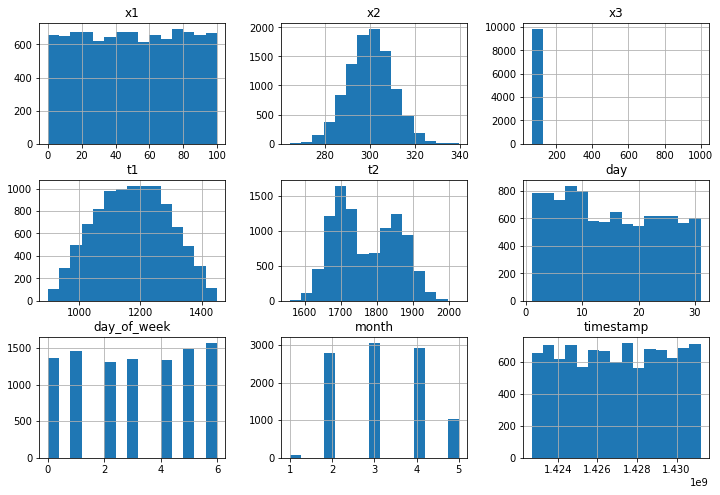

In [7]:
plt.rcParams["figure.figsize"] = [12, 8]
hist = df[['x1', 'x2', 'x3', 't1', 't2', 'day', 'day_of_week', 'month', 'timestamp']].hist(bins=15)


In [8]:
df.describe()

ids           x1           x2           x3           t1  \
count   9868.000000  9868.000000  9868.000000  9868.000000  9868.000000   
mean    5000.702067    50.057630   300.066508    95.064154  1174.761003   
std     2886.353539    28.927412     9.882410     9.964247   118.643741   
min        1.000000     0.004004   264.463035    62.029833   897.883743   
25%     2500.750000    24.719006   293.397245    93.002468  1084.746402   
50%     4996.500000    49.852141   300.225596    95.898262  1175.303598   
75%     7501.250000    75.370966   306.542491    97.997047  1264.185866   
max    10000.000000    99.904798   339.416551  1000.000000  1449.617809   

                t2          day  day_of_week        month    year  \
count  9868.000000  9868.000000  9868.000000  9868.000000  9868.0   
mean   1769.220676    14.582894     3.071240     3.203385  2015.0   
std      86.212014     8.839579     2.031796     0.993381     0.0   
min    1557.852139     1.000000     0.000000     1.000000  2015.0   
25%    1696.162647     7.000000     1.000000     2.000000  2015.0   
50%    1752.607393    14.000000     3.000000     3.000000  2015.0   
75%    1846.619457    22.000000     5.000000     4.000000  2015.0   
max    2027.374480    31.000000     6.000000     5.000000  2015.0   

          timestamp  outlier  
count  9.868000e+03   9868.0  
mean   1.426953e+09      0.0  
std    2.503050e+06      0.0  
min    1.422662e+09      0.0  
25%    1.424736e+09      0.0  
50%    1.426982e+09      0.0  
75%    1.429142e+09      0.0  
max    1.431216e+09      0.0

In [9]:
print(f"Gender mode is: {df.gender.mode()[0]}")
print(f"Last connection mode is: {df.last_connection.mode()[0]}")
print(f"X1 mode is: {df.mode()['x1'][0]}")
print(f"X2 mode is: {df.mode()['x2'][0]}")
print(f"X3 mode is: {df.mode()['x3'][0]}")
print(f"T1 mode is: {df.mode()['t1'][0]}")
print(f"T2 mode is: {df.mode()['t2'][0]}")

Gender mode is: M
Last connection mode is: 2015-02-10 00:00:00
X1 mode is: 0.004003639333
X2 mode is: 289.0426929
X3 mode is: 62.02983306
T1 mode is: 897.883743
T2 mode is: 1557.852139


# Step 2 Correlation exploration

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e985cb890>,
      dtype=object)

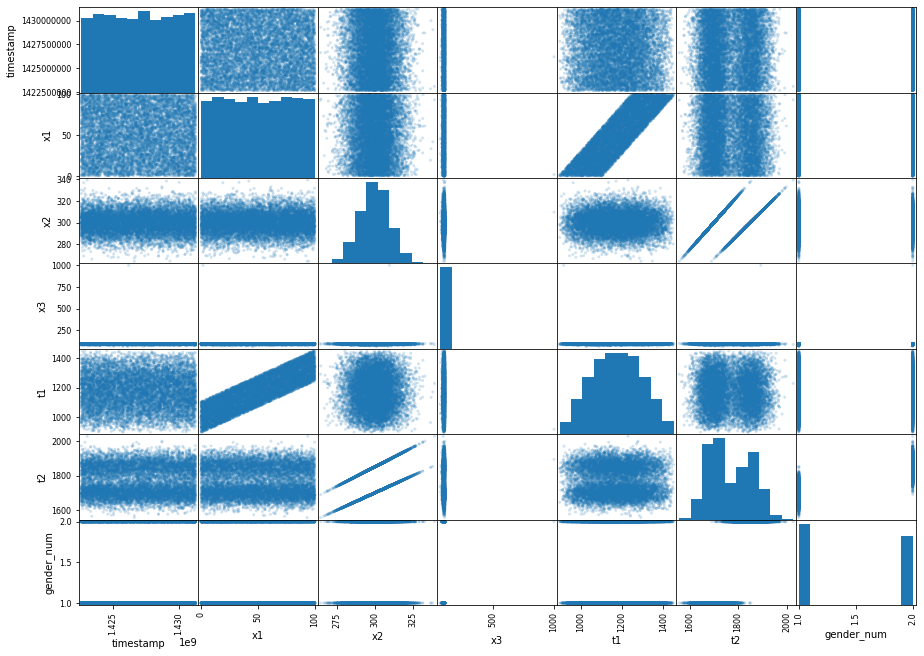

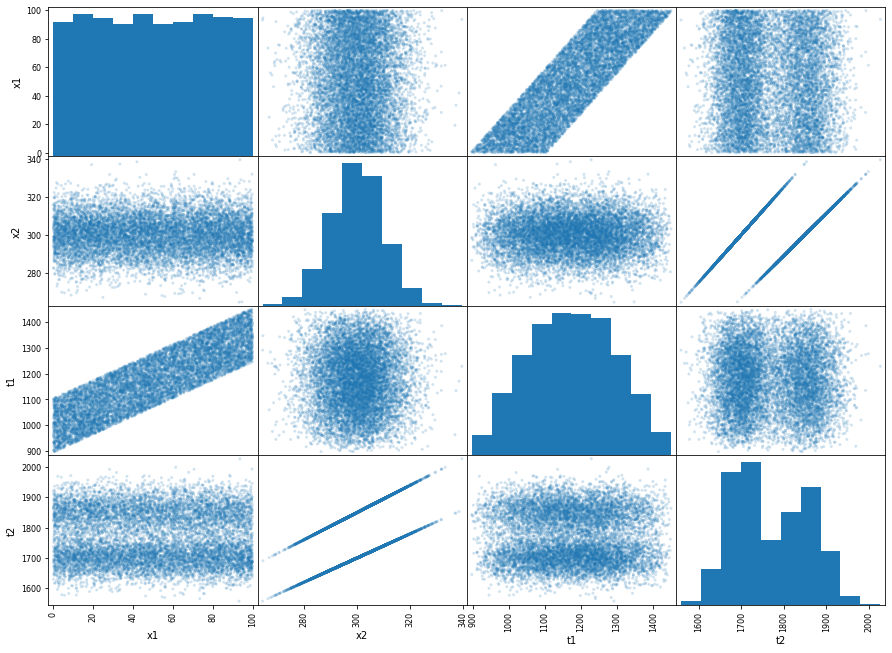

In [10]:
plt.rcParams["figure.figsize"] = [15, 11]
scdf = df[['timestamp','gender', 'x1', 'x2', 'x3', 't1', 't2']]
scdf['gender_num'] = np.where(scdf['gender'] == 'M', 1, 2)
pd.plotting.scatter_matrix(scdf, alpha=0.2)
scdf = df[['x1', 'x2', 't1', 't2']]
pd.plotting.scatter_matrix(scdf, alpha=0.2)

In [11]:
corr_matrix = scdf.corr()
corr_matrix

x1        x2        t1        t2
x1  1.000000 -0.005408  0.860186 -0.024553
x2 -0.005408  1.000000  0.002690  0.496988
t1  0.860186  0.002690  1.000000 -0.014305
t2 -0.024553  0.496988 -0.014305  1.000000

In [12]:
corr_matrix.style.background_gradient(cmap='Spectral', axis=0)


# Correlation without math

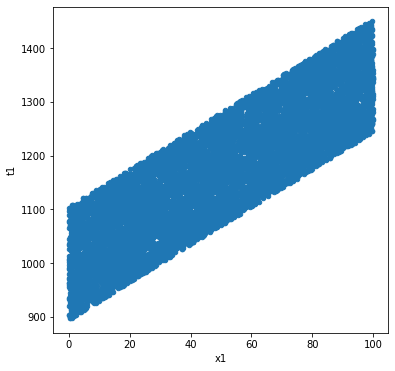

In [13]:
plt.rcParams["figure.figsize"] = [6, 6]
df.plot.scatter(x = 'x1', y = 't1')

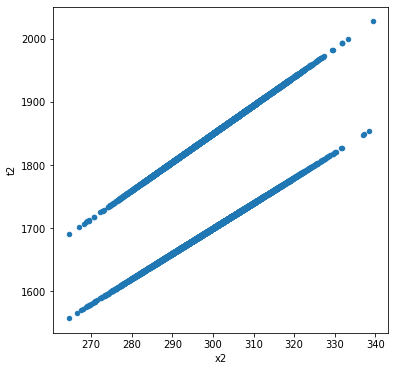

In [14]:
df.plot.scatter(x = 'x2', y = 't2')